# Фильтр Калмана

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
np.random.seed(100)
import matplotlib as mlp
mlp.rcParams["legend.loc"] = 'upper right'
mlp.rcParams["legend.framealpha"] = 1
mlp.rcParams["legend.edgecolor"] = 'k'
mlp.rcParams["legend.fancybox"] = False
mlp.rcParams['font.size'] = 12
mlp.rcParams["legend.fontsize"] = 'small'
mlp.rcParams["axes.labelsize"] = 'large'



2. Получение измеренрий скорости

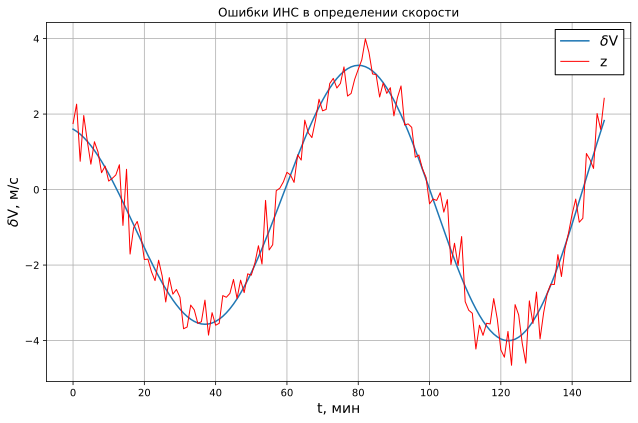

In [2]:
np.random.seed(42)
def get_theoretical(x, T=1, sigma=1e-8,  B=1e-4):
    # initial condition of parameters
    T = 1 # период дискретизации 1 сек
    b = 0.02 # cредняя частота случайного дрейфа с^-1
    R = 6370000 # Радиус земли м
    g =  9.8*3600 #ускорение свободного падения м/с**2
#     dv = 1.6 # начальные погрешности скорости м/с
#     phi = 1e-4 # начальные углы отклонения ГСП рад
#     e = 1e-5/60# скорость дрейфа ГСП рад/с

    F = np.array([[1,  -g*T,  0],
                  [T/R, 1,  T],
                  [0,   0,  1-b*T]])
    w = np.array([[B, 0, np.random.randn()*sigma*T*np.sqrt(2*b)]]).T
    x = F @ x + w
    return x

x = np.array([[1.6*60,1e-4,1e-5]]).T
v = np.array([])
phi = np.array([])
e = np.array([])

v = np.concatenate((v, x[0]))
phi = np.concatenate((phi, x[1]))
e = np.concatenate((e, x[2]))

t = np.arange(0,150)[:,np.newaxis]
for i in range(len(t)-1):
    x = get_theoretical(x,10)
    v = np.concatenate((v, x[0]))
    phi = np.concatenate((phi, x[1]))
    e = np.concatenate((e, x[2]))
    
z = v + -0.5*60 + 2*np.random.rand(len(v))*0.5*60
z = v + np.random.randn(len(v))*0.5*60 
    
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(t, v/60, label='$\delta$V')
ax.plot(t, z/60, lw=1, c='r', label='z')
ax.set_xlabel('t, мин', fontsize=14)
ax.set_ylabel('$\delta$V, м/с', fontsize=14)
ax.set_title('Ошибки ИНС в определении скорости')
plt.grid()
plt.legend(fontsize=14)
fig.tight_layout()
plt.savefig(r'D:\мага\КП_НИР\отчет\1.png', dpi=300,bbox_inches = 'tight')


3. Напишем класс Фильтра Калмана

In [10]:
np.random.seed(42)
class KalmanFilter:
    def __init__(self,P, Q, R, H):
        self.P = P #cov matrix state
        self.Q = Q #cov matrix process
        self.R = R #cov matrix measure
        self.H = H #matrix measure
        self.K = np.array([[0,0,0]]).T
        self.x_est = np.array([[0], [0], [0]])
        self.P_V = np.array(self.P[0,0])
        self.P_phi = np.array(self.P[1,1])
        self.P_e = np.array(self.P[2,2])
        
        T = 1 # период дискретизации 1 сек
        b = 0.02 # cредняя частота случайного дрейфа с^-1
        R = 6370000 # Радиус земли м
        g =  9.8*3600 #ускорение свободного падения м/с**2
        self.F = np.array([[1,  -g*T,  0],
                      [T/R, 1,  T],
                      [0,   0,  1-b*T]])

    def filtr(self, z):
        self.x_est[0,0] = z[0]
        for i in range(1, len(z)):
            #predict
            x = self.F @ self.x_est[:,-1][:,np.newaxis]
#             x[0,0] *= 0.5
            y = z[i] - self.H @ x
            self.P = self.F @ self.P @ self.F.T + self.Q
            
            #update
            Ht = self.H.T
            K = self.P @ Ht @ np.linalg.inv(self.H @ self.P @ Ht + self.R)
            self.x_est = np.hstack((self.x_est, x + K @ y))
            I = np.eye(len(x))
            self.P = (I - K @ self.H) @ self.P
            self.K = K
            
            #logs
            self.P_V = np.hstack((self.P_V,self.P[0,0]))
            self.P_phi = np.hstack((self.P_phi,self.P[1,1]))
            self.P_e = np.hstack((self.P_e,self.P[2,2]))
  
        
        return self.x_est, self.P_V, self.P_phi, self.P_e

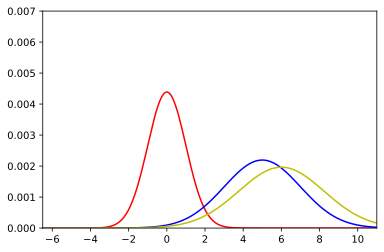

In [11]:
from scipy import integrate

def gaussian(x, m, d):
    g = 1/d/np.sqrt(2*np.pi)*np.exp(-1/2*(x-m)**2/(d**2))
    g = g/sum(g)
    return g

def sum_gaussian(x, m1, d1, m2, d2):
    m = m1 + m2
    d = d1**2 +d2**2
    return gaussian(x, m, np.sqrt(d))

def prod_gaussian(x, m1, d1, m2, d2):
    m = (d1**2*m2 + d2**2*m1)/(d1**2 + d2**2)
    d = (d1**2*d2**2)/(d1**2 + d2**2)
    return gaussian(x, m, d)
    
m1 = 0
m2 = 5
d1 = 1
d2 = 2

x = np.linspace(-10,100,10000)
g1 = gaussian(x,m1, d1)
g2 = gaussian(x, m2, d2)
plt.plot(x, g1, c='r')
plt.plot(x, g2, c='b')
# g = np.convolve(g1, g2)
# g = g/sum(g)
g_p = prod_gaussian(x, m1, d1, m2, d2)
g_s = sum_gaussian(x, m1+1, d1, m2, d2)
# plt.plot(x,g_p, c='k')
plt.plot(x,g_s, c='y')
plt.xlim(-6.5,11)
plt.ylim(-0,0.007)

fig.tight_layout()
# print(integrate.quad(gaussian, -3,6, args=(2.6,0.5)))

In [12]:
np.random.seed(42)
B=1e-4
sigma=1e-8
w = np.array([[B, 0, np.random.randn()*sigma]]).T
for i in range(1,150):
    w1 = np.array([[B, 0, np.random.randn()*sigma*1*np.sqrt(2*0.05)]]).T
    w = np.hstack((w, w1))
    
COV = np.cov(w)
COV

array([[ 7.39614734e-40,  0.00000000e+00, -3.00950006e-46],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.00950006e-46,  0.00000000e+00,  9.04046972e-18]])

# Оптимальный фильтр

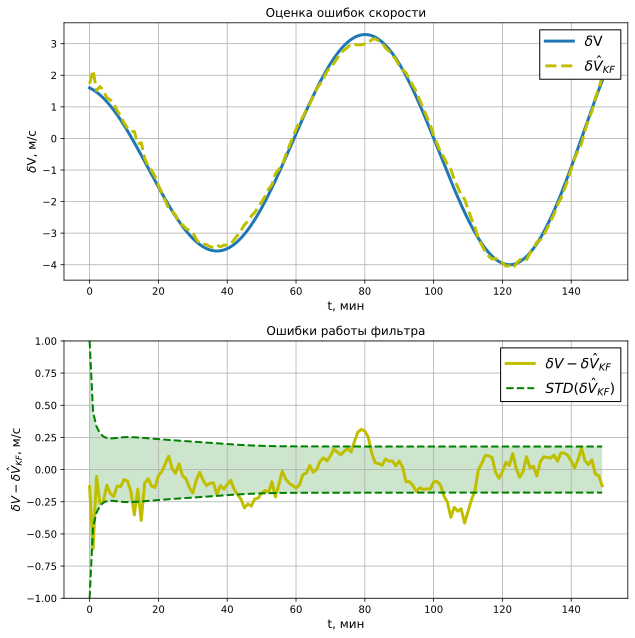

In [16]:
np.random.seed(42)
z_sco = 0.5*60
v0_sco = 1*60
phi0_sco = 1e-4
e0_sco = 1e-5
P = np.diag([v0_sco**2, phi0_sco**2, e0_sco**2])
Q = np.diag([0,0,5e-13])
# Q = np.diag([1000, phi0_sco**2, e0_sco**2])
R = np.diag([z_sco**2])
H = np.array([[1,0,0]])

KF = KalmanFilter(P, Q, R, H)
x_est, P_V, P_phi, P_e = KF.filtr(z)




fig, ax = plt.subplots(2,1, figsize=(9,9))
ax[0].plot(t, v/60,lw=3, label='$\delta$V')
# ax[0].plot(t, z/60, '--', lw=1.5, c='r', label='z')
ax[0].plot(t, x_est[0,:]/60, '--', lw=3, c='y', label='$\delta$$\hat{V}_{KF}$')
ax[0].set_xlabel('t, мин')
ax[0].set_ylabel('$\delta$V, м/с')
ax[0].set_title('Оценка ошибок скорости')
ax[0].grid()
ax[0].legend(fontsize=14)





ax[1].plot(t, (v - x_est[0,:])/60, c='y',lw=3, label=r'$\delta{V}-\delta\hat{V}_{KF}$')
ax[1].plot(t, np.sqrt(P_V)/60, '--', lw=2, c='g',label=r'$STD(\delta{\hat{V}}_{KF})$')
ax[1].plot(t, -np.sqrt(P_V)/60, '--', lw=2, c='g')
ax[1].fill_between(t.ravel(), -np.sqrt(P_V)/60, np.sqrt(P_V)/60, facecolor='g', alpha=0.2)
ax[1].grid()
ax[1].legend(fontsize=14)
ax[1].set_ylim([-1,1])
ax[1]
ax[1].set_title('Ошибки работы фильтра')
ax[1].set_xlabel('t, мин')
ax[1].set_ylabel('$\delta{V}-\delta\hat{V}_{KF}$, м/с')
ax[1].ticklabel_format(axis='y', scilimits=[0, 0])

fig.tight_layout()
plt.savefig(r'D:\мага\КП_НИР\отчет\2.png', dpi=300,bbox_inches = 'tight')

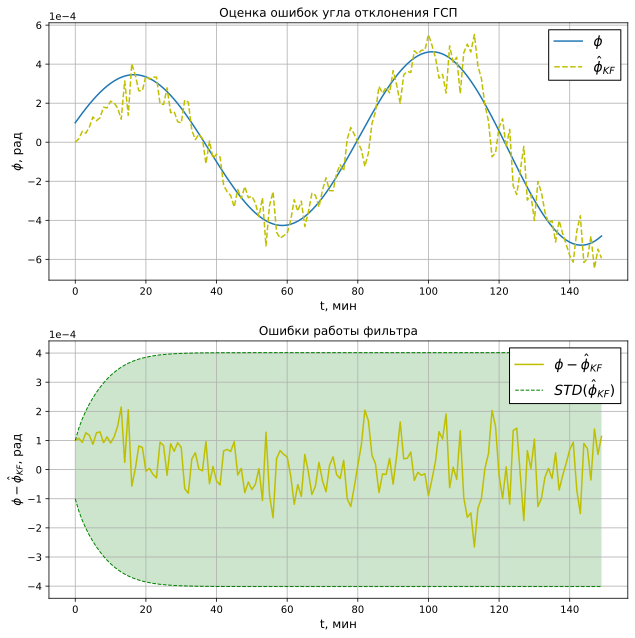

In [15]:
fig, ax = plt.subplots(2,1, figsize=(9,9))
ax[0].plot(t, phi, lw=1.5, label='$\phi$')
ax[0].plot(t, x_est[1,:], '--', lw=1.5, c='y', label='$\hat{\phi}_{KF}$')
ax[0].ticklabel_format(axis='y', scilimits=[-3, 3])
ax[0].set_xlabel('t, мин')
ax[0].set_ylabel('$\phi$, рад')
ax[0].set_title('Оценка ошибок угла отклонения ГСП')
ax[0].grid()
ax[0].legend(fontsize=14)


ax[1].plot(t, (phi-x_est[1,:]), c='y', label=r'$\phi-\hat{\phi}_{KF}$')
ax[1].plot(t, np.sqrt(P_phi), '--', lw=1, c='g',label=r'$STD({\hat{\phi}}_{KF})$')
ax[1].plot(t, -np.sqrt(P_phi), '--', lw=1, c='g')
ax[1].fill_between(t.ravel(), -np.sqrt(P_phi), np.sqrt(P_phi), facecolor='g', alpha=0.2)
ax[1].grid()
ax[1].legend(fontsize=14)
# ax[1].set_ylim([-1,1])
ax[1]
ax[1].set_title('Ошибки работы фильтра')
ax[1].set_xlabel('t, мин')
ax[1].set_ylabel('$\phi-\hat{\phi}_{KF}$, рад')
ax[1].ticklabel_format(axis='y', scilimits=[0, 0])

fig.tight_layout()
plt.savefig(r'D:\мага\КП_НИР\отчет\3.png', dpi=300,bbox_inches = 'tight')

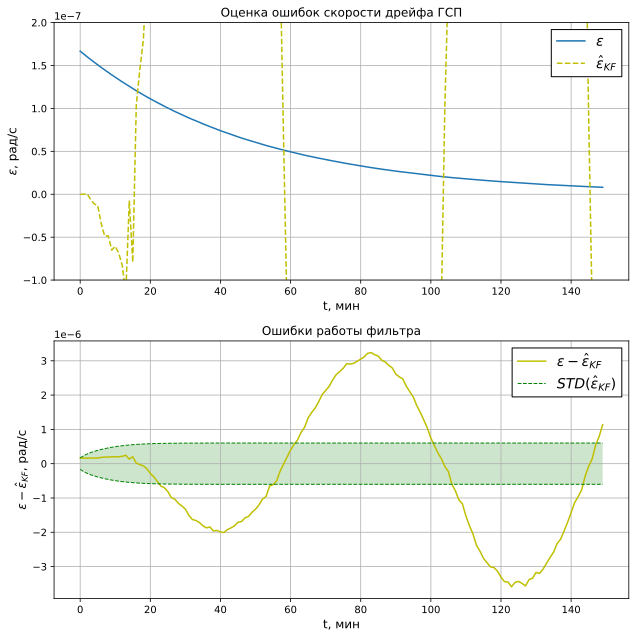

In [9]:
fig, ax = plt.subplots(2,1, figsize=(9,9))
ax[0].plot(t, e/60,lw=1.5, label='$\epsilon$')
ax[0].plot(t, x_est[2,:]/60, '--', lw=1.5, c='y', label='$\hat{\epsilon}_{KF}$')
ax[0].ticklabel_format(axis='y', scilimits=[-3, 3])
ax[0].set_xlabel('t, мин')
ax[0].set_ylabel('$\epsilon$, рад/с')
ax[0].set_title('Оценка ошибок скорости дрейфа ГСП')
ax[0].set_ylim(-1e-7, 2e-7)
ax[0].grid()
ax[0].legend(fontsize=14)

ax[1].plot(t, (e-x_est[2,:])/60,  lw=1.5, c='y', label='$\epsilon-\hat{\epsilon}_{KF}$')
ax[1].plot(t, np.sqrt(P_e)/60, '--', lw=1, c='g', label='$STD(\hat{\epsilon}_{KF})$')
ax[1].plot(t, -np.sqrt(P_e)/60, '--', lw=1, c='g')
ax[1].fill_between(t.ravel(), -np.sqrt(P_e)/60, np.sqrt(P_e)/60, facecolor='g', alpha=0.2)
ax[1].grid()
ax[1].legend(fontsize=14)
ax[1].set_title('Ошибки работы фильтра')
ax[1].set_xlabel('t, мин')
ax[1].set_ylabel('$\epsilon-\hat{\epsilon}_{KF}$, рад/с')

fig.tight_layout()
plt.savefig(r'D:\мага\КП_НИР\отчет\4.png', dpi=300,bbox_inches = 'tight')

# Сравнение с адаптивным

In [10]:
np.random.seed(42)
class AdaptiveKalmanFilter:
    def __init__(self,P, R, H):
        self.P = P #cov matrix state
        self.R = R #cov matrix measure
        self.H = H #matrix measure
        self.K = np.array([[0,0,0]]).T
        self.x_est = np.array([[0], [0], [0]])
        self.P_V = [self.P[0,0]]
        self.P_V = np.array(self.P[0,0])
        self.P_phi = np.array(self.P[1,1])
        self.P_e = np.array(self.P[2,2])
        self.M = 0
        self.pred = np.array([0])
        print(self.x_est)
        
        T = 1 # период дискретизации 1 сек
        b = 0.02 # cредняя частота случайного дрейфа мин^-1
        R = 6370000 # Радиус земли м
        g =  9.8*3600 #ускорение свободного падения м/с**2
        self.F = np.array([[1,  -g*T,  0],
                      [T/R, 1,  T],
                      [0,   0,  1-b*T]])

    def filtr(self, z):
        self.x_est[0,0] = z[0]
        print(self.x_est)
        
        for i in range(1, len(z)):
            #predict
            x = self.F @ self.x_est[:,-1][:,np.newaxis]
            self.pred = np.hstack((self.pred, x[0]))
            y = z[i] - self.H @ x
            self.M = (i-1)*self.M + y*y.T
            self.M = sum(self.M)/i
            self.P = self.F @ self.P @ self.F.T + self.K * self.M * self.K.T
#             self.P = self.P + self.K * self.M * self.K.T
            
            #update
            Ht = self.H.T
            K = self.P @ Ht @ np.linalg.inv(self.H @ self.P @ Ht + self.M)
#             K = self.P @ Ht / (y*y)

            self.x_est = np.hstack((self.x_est, x + K @ y))
            I = np.eye(len(x))
            self.P = (I - K @ self.H) @ self.P
            self.K = K
            
            #logs
            self.P_V = np.hstack((self.P_V,self.P[0,0]))
            self.P_phi = np.hstack((self.P_phi,self.P[1,1]))
            self.P_e = np.hstack((self.P_e,self.P[2,2]))

  
        return self.x_est, self.P_V, self.P_phi, self.P_e

[[0]
 [0]
 [0]]
[[104]
 [  0]
 [  0]]


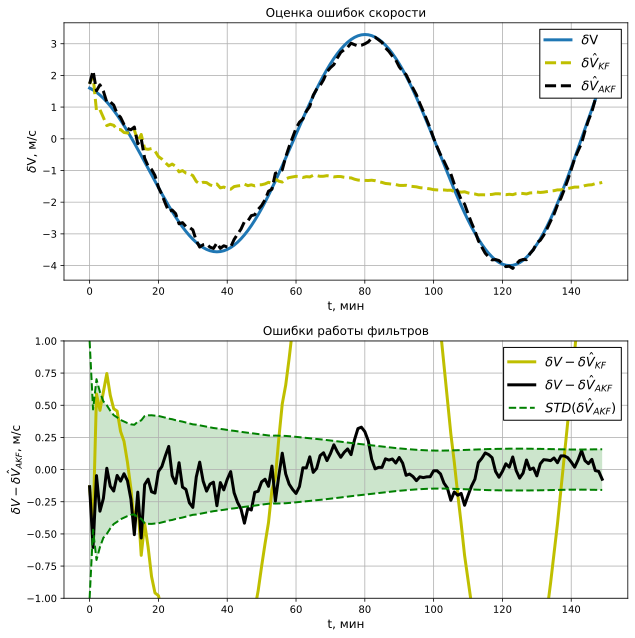

In [11]:
np.random.seed(42)
z_sco = 0.5*60
v0_sco = 1*60
phi0_sco = 1e-4
e0_sco = 1e-5
P = np.diag([v0_sco**2, phi0_sco**2, e0_sco**2])
# Q = np.diag([0,0,5e-13])
Q = COV
R = np.diag([z_sco**2])
H = np.array([[1,0,0]])

KF = KalmanFilter(P, Q, R, H)
x_est, P_V, P_phi, P_e = KF.filtr(z)

AKF = AdaptiveKalmanFilter(P, R, H)
x_est1, P_V1, P_phi1, P_e1 = AKF.filtr(z)



fig, ax = plt.subplots(2,1, figsize=(9,9))
ax[0].plot(t, v/60,lw=3, label='$\delta$V')
# ax.plot(t, z/60, '--', lw=1, c='r', label='z')
ax[0].plot(t, x_est[0,:]/60, '--', lw=3, c='y', label='$\delta$$\hat{V}_{KF}$')
ax[0].plot(t, x_est1[0,:]/60, '--', lw=3, c='k', label='$\delta$$\hat{V}_{AKF}$')
ax[0].set_xlabel('t, мин')
ax[0].set_ylabel('$\delta$V, м/с')
ax[0].set_title('Оценка ошибок скорости')
ax[0].grid()
ax[0].legend(fontsize=13)




ax[1].plot(t, (v - x_est[0,:])/60, c='y',lw=3, label=r'$\delta{V}-\delta\hat{V}_{KF}$')
ax[1].plot(t, (v - x_est1[0,:])/60, c='k', lw=3,label=r'$\delta{V}-\delta\hat{V}_{AKF}$')
ax[1].plot(t, np.sqrt(P_V1)/60, '--', lw=2, c='g',label=r'$STD(\delta{\hat{V}}_{AKF})$')
ax[1].plot(t, -np.sqrt(P_V1)/60, '--', lw=2, c='g')
ax[1].fill_between(t.ravel(), -np.sqrt(P_V1)/60, np.sqrt(P_V1)/60, facecolor='g', alpha=0.2)
ax[1].grid()
ax[1].legend(fontsize=13)
ax[1].set_ylim([-1,1])
ax[1]
ax[1].set_title('Ошибки работы фильтров')
ax[1].set_xlabel('t, мин')
ax[1].set_ylabel('$\delta{V}-\delta\hat{V}_{AKF}$, м/с')
ax[1].ticklabel_format(axis='y', scilimits=[0, 0])

fig.tight_layout()
plt.savefig(r'D:\мага\КП_НИР\отчет\7.png', dpi=300,bbox_inches = 'tight')


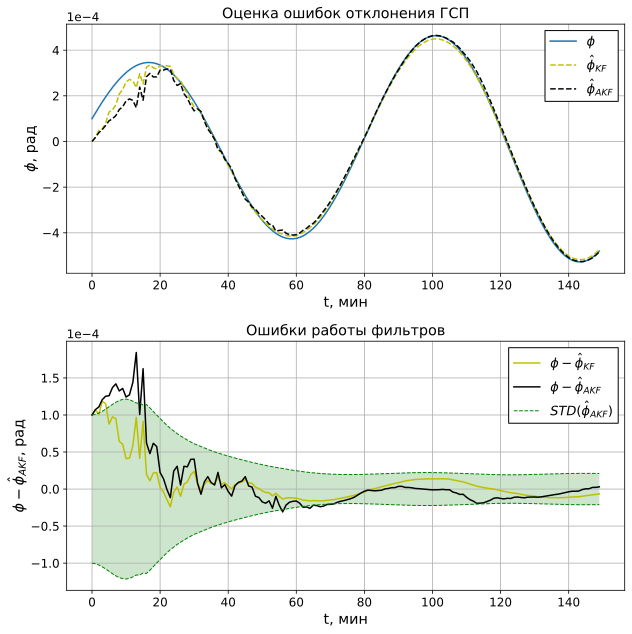

In [11]:
fig, ax = plt.subplots(2,1, figsize=(9,9))
ax[0].plot(t, phi, lw=1.5, label='$\phi$')
ax[0].plot(t, x_est[1,:], '--', lw=1.5, c='y', label='$\hat{\phi}_{KF}$')
ax[0].plot(t, x_est1[1,:],'--', lw=1.5, c='k', label='$\hat{\phi}_{AKF}$')
ax[0].ticklabel_format(axis='y', scilimits=[-3, 3])
ax[0].set_xlabel('t, мин')
ax[0].set_ylabel('$\phi$, рад')
ax[0].set_title('Оценка ошибок отклонения ГСП')
ax[0].grid()
ax[0].legend(fontsize=13)



ax[1].plot(t, (phi-x_est[1,:]), c='y', label=r'$\phi-\hat{\phi}_{KF}$')
ax[1].plot(t, (phi-x_est1[1,:]), c='k', label=r'$\phi-\hat{\phi}_{AKF}$')
ax[1].plot(t, np.sqrt(P_phi1), '--', lw=1, c='g',label=r'$STD({\hat{\phi}}_{AKF})$')
ax[1].plot(t, -np.sqrt(P_phi1), '--', lw=1, c='g')
ax[1].fill_between(t.ravel(), -np.sqrt(P_phi1), np.sqrt(P_phi1), facecolor='g', alpha=0.2)
ax[1].grid()
ax[1].legend(fontsize=13)
# ax[1].set_ylim([-1,1])
ax[1]
ax[1].set_title('Ошибки работы фильтров')
ax[1].set_xlabel('t, мин')
ax[1].set_ylabel('$\phi-\hat{\phi}_{AKF}$, рад')
ax[1].ticklabel_format(axis='y', scilimits=[0, 0])

fig.tight_layout()
plt.savefig(r'D:\мага\КП_НИР\отчет\8.png', dpi=300,bbox_inches = 'tight')

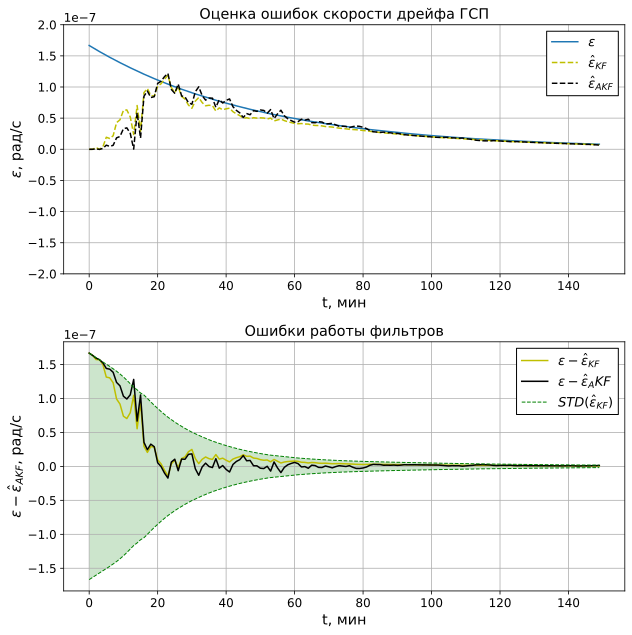

In [12]:
fig, ax = plt.subplots(2,1, figsize=(9,9))
ax[0].plot(t, e/60,lw=1.5, label='$\epsilon$')
ax[0].plot(t, x_est[2,:]/60, '--', lw=1.5, c='y', label='$\hat{\epsilon}_{KF}$')
ax[0].plot(t, x_est1[2,:]/60, '--', lw=1.5, c='k', label='$\hat{\epsilon}_{AKF}$')
ax[0].ticklabel_format(axis='y', scilimits=[-3, 3])
ax[0].set_xlabel('t, мин')
ax[0].set_ylabel('$\epsilon$, рад/с')
ax[0].set_title('Оценка ошибок скорости дрейфа ГСП')
ax[0].set_ylim(-2e-7, 2e-7)
# plt.savefig(r'D:\мага\КП_НИР\отчет\saved_figure.png')
ax[0].grid()
ax[0].legend(fontsize=13)

ax[1].plot(t, (e-x_est[2,:])/60,  lw=1.5, c='y', label='$\epsilon-\hat{\epsilon}_{KF}$')
ax[1].plot(t, (e-x_est1[2,:])/60,  lw=1.5, c='k', label='$\epsilon-\hat{\epsilon}_AKF}$')
ax[1].plot(t, np.sqrt(P_e1)/60, '--', lw=1, c='g', label='$STD(\hat{\epsilon}_{KF})$')
ax[1].plot(t, -np.sqrt(P_e1)/60, '--', lw=1, c='g')
ax[1].fill_between(t.ravel(), -np.sqrt(P_e1)/60, np.sqrt(P_e1)/60, facecolor='g', alpha=0.2)
ax[1].grid()
ax[1].legend(fontsize=13)
ax[1].set_title('Ошибки работы фильтров')
ax[1].set_xlabel('t, мин')
ax[1].set_ylabel('$\epsilon-\hat{\epsilon}_{AKF}$, рад/с')

fig.tight_layout()
plt.savefig(r'D:\мага\КП_НИР\отчет\9.png', dpi=300,bbox_inches = 'tight')


# 1. Исследование в зависимости от матрицы Q

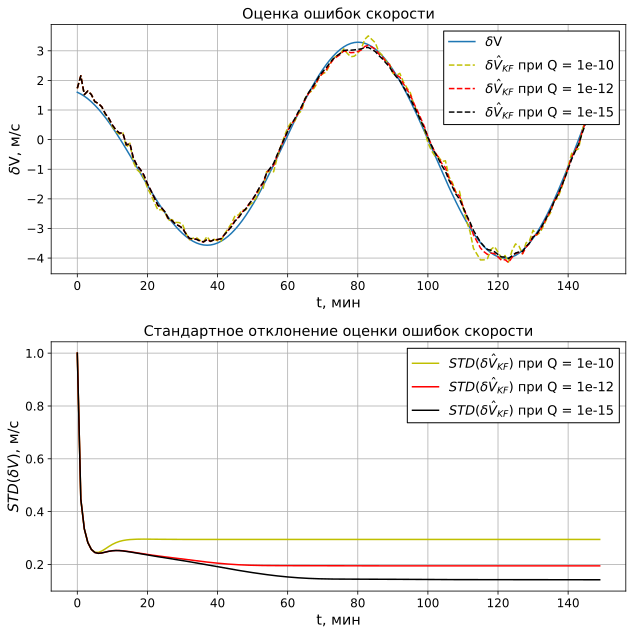

In [13]:
np.random.seed(42)
z_sco = 0.5*60
v0_sco = 1*60
phi0_sco = 1e-4
e0_sco = 1e-5
P = np.diag([v0_sco**2, phi0_sco**2, e0_sco**2])

Q = (np.diag([0,0,1e-10]), np.diag([0,0,1e-12]), np.diag([0,0,1e-13]))
R = np.diag([z_sco**2])
H = np.array([[1,0,0]])


fig, ax = plt.subplots(2,1, figsize=(9,9))

ax[0].plot(t, v/60, lw=1.5, label='$\delta$V')

c = {0: 'y', 1: 'r', 2: 'k'}
i = 0
Qr = {0: '1e-10', 1: '1e-12', 2: '1e-15'}
for q in Q:
    KF = KalmanFilter(P, q, R, H)
    x_est, P_V, P_phi, P_e = KF.filtr(z)
    ax[0].plot(t, x_est[0,:]/60, '--', lw=1.5, c=c[i], label='$\delta$$\hat{V}_{KF}$ при Q = '+f'{Qr[i]}')
    ax[0].grid()
    ax[0].legend(fontsize=13)
    ax[1].plot(t, np.sqrt(P_V)/60, label=r'$STD(\delta{\hat{V}}_{KF})$ при Q = '+f'{Qr[i]}', c=c[i])
    i += 1
    ax[1].grid()
    ax[1].legend(fontsize=13)


ax[0].set_xlabel('t, мин')
ax[0].set_ylabel('$\delta$V, м/с')
ax[0].set_title('Оценка ошибок скорости')



ax[1].set_title('Стандартное отклонение оценки ошибок скорости')
ax[1].set_xlabel('t, мин')
ax[1].set_ylabel('$STD(\delta{V})$, м/с')


fig.tight_layout()
plt.savefig(r'D:\мага\КП_НИР\отчет\5.png',dpi=300,bbox_inches = 'tight')


# fig1, ax1 = plt.subplots(3,1, figsize=(8,8))
# i = 0
# for q in Q:
#     KF = KalmanFilter(P, q, R, H)
#     x_est, P_V, P_phi, P_e = KF.filtr(z)
#     ax1[i].plot(t, (v-x_est[0,:])/60, lw=1.5, c=c[i], label='$\delta{V}-\delta\hat{V}_{KF}$ при Q = '+f'{Qr[i]}')
#     ax1[i].plot(t, np.sqrt(P_V)/60, '--', lw=1, c='g')
#     ax1[i].plot(t, -np.sqrt(P_V)/60, '--', lw=1, c='g')
#     ax1[i].fill_between(t.ravel(), -np.sqrt(P_V)/60, np.sqrt(P_V)/60, facecolor='g', alpha=0.2)
#     ax1[i].grid()
#     ax1[i].legend()
#     ax1[i].set_ylim([-1,2])
#     ax1[i]
#     ax1[0].set_title('Ошибки фильтра в определении скорости')
#     ax1[i].set_xlabel('t, мин')
#     ax1[i].set_ylabel('$\delta{v}-\delta\hat{v}_{KF}$, м/с')
#     i += 1

# fig1.tight_layout()

In [14]:

# fig, ax = plt.subplots(2,1, figsize=(8,8))

# ax[0].plot(t, phi, lw=1.5, label='$\Phi$')

# c = {0: 'y', 1: 'r', 2: 'k'}
# i = 0
# Qr = {0: '1e-10', 1: '1e-12', 2: '1e-15'}
# for q in Q:
#     KF = KalmanFilter(P, q, R, H)
#     x_est, P_V, P_phi, P_e = KF.filtr(z)
#     ax[0].plot(t, x_est[1,:],'--',  lw=1.5, c=c[i], label='$\hat{\Phi}_{KF}$ при Q = '+f'{Qr[i]}')
#     ax[0].grid()
#     ax[0].legend()
#     ax[1].plot(t, np.sqrt(P_phi), label=r'$STD(\hat{\Phi}_{KF})$ при Q = '+f'{Qr[i]}', c=c[i])
#     i += 1
#     ax[1].grid()
#     ax[1].legend()


# ax[0].ticklabel_format(axis='y', scilimits=[-3, 3])
# ax[0].set_xlabel('t, мин')
# ax[0].set_ylabel('$\Phi$, рад')
# ax[0].set_title('Ошибки ИНС в определении угла отклонения ГСП')




# ax[1].set_title('Стандартное отклонение ошибок угла отклонения ГСП')
# ax[1].ticklabel_format(axis='y', scilimits=[-3, 3])
# ax[1].set_ylabel('$STD(\Phi)$, рад')
# ax[1].set_xlabel('t, мин')

# fig.tight_layout()
# plt.savefig(r'D:\мага\КП_НИР\отчет\6.png',dpi=300)


# fig1, ax1 = plt.subplots(3,1, figsize=(8,8))
# i = 0
# for q in Q:
#     KF = KalmanFilter(P, q, R, H)
#     x_est, P_V, P_phi, P_e = KF.filtr(z)
#     ax1[i].plot(t, (phi-x_est[1,:]),  lw=1.5, c=c[i], label='$\Phi-\hat{\Phi}_{KF}$ при Q = '+f'{Qr[i]}')
#     ax1[i].plot(t, np.sqrt(P_phi), '--', lw=1, c='g')
#     ax1[i].plot(t, -np.sqrt(P_phi), '--', lw=1, c='g')
#     ax1[i].fill_between(t.ravel(), -np.sqrt(P_phi), np.sqrt(P_phi), facecolor='g', alpha=0.2)
#     ax1[i].grid()
#     ax1[i].legend()
# #     ax1[i].set_ylim([-1,2])
#     ax1[i]
#     ax1[0].set_title('Ошибки фильтра в определении угла отклонения ГСП')
#     ax1[i].set_xlabel('t, мин')
#     ax1[i].set_ylabel('$\Phi-\hat{\Phi}_{KF}$, рад')
#     ax1[i].ticklabel_format(axis='y', scilimits=[-3, 3])
#     i += 1
    
# fig1.tight_layout()

In [15]:
# fig, ax = plt.subplots(2,1, figsize=(8,8))

# ax[0].plot(t, e, lw=1.5, label='$\epsilon$')

# c = {0: 'y', 1: 'r', 2: 'k'}
# i = 0
# Qr = {0: '1e-10', 1: '1e-12', 2: '1e-15'}
# for q in Q:
#     KF = KalmanFilter(P, q, R, H)
#     x_est, P_V, P_phi, P_e = KF.filtr(z)
#     ax[0].plot(t, x_est[2,:], '--', lw=1.5, c=c[i], label='$\hat{\epsilon}_{KF}$ при Q = '+f'{Qr[i]}')
#     ax[0].grid()
#     ax[0].legend()
#     ax[1].plot(t, np.sqrt(P_e), c=c[i], label=r'$STD(\hat{\epsilon}_{KF})$ при Q = '+f'{Qr[i]}')
#     ax[1].grid()
#     ax[1].legend()
#     i += 1




# ax[0].ticklabel_format(axis='y', scilimits=[-3, 3])
# ax[0].set_xlabel('t, мин')
# ax[0].set_ylabel('$\epsilon$, рад/с')
# ax[0].set_title('Ошибки ИНС в определении скорости дрейфа ГСП')


# ax[1].set_title('Стандартное отклонение скорости дрейфа ГСП')
# ax[1].ticklabel_format(axis='y', scilimits=[-3, 3])
# ax[1].set_ylabel('$STD(\epsilon)$, рад')
# ax[1].set_xlabel('t, мин')



# fig.tight_layout()
# plt.savefig(r'D:\мага\КП_НИР\отчет\7.png',dpi=300)


# fig1, ax1 = plt.subplots(3,1, figsize=(8,8))
# i = 0
# for q in Q:
#     KF = KalmanFilter(P, q, R, H)
#     x_est, P_V, P_phi, P_e = KF.filtr(z)
#     ax1[i].plot(t, (e-x_est[2,:])/60,  lw=1.5, c=c[i], label='$\epsilon-\hat{\epsilon}_{KF}$ при Q = '+f'{Qr[i]}')
#     ax1[i].plot(t, np.sqrt(P_e)/60, '--', lw=1, c='g')
#     ax1[i].plot(t, -np.sqrt(P_e)/60, '--', lw=1, c='g')
#     ax1[i].fill_between(t.ravel(), -np.sqrt(P_e)/60, np.sqrt(P_e)/60, facecolor='g', alpha=0.2)
#     ax1[i].grid()
#     ax1[i].legend()
# #     ax1[i].set_ylim([-1,2])
#     ax1[i]
#     ax1[0].set_title('Ошибки фильтра в определении скорости дрейфа ГСП')
#     ax1[i].set_xlabel('t, мин')
#     ax1[i].set_ylabel('$\epsilon-\hat{\epsilon}_{KF}$, рад/с')
#     i += 1
    
# fig1.tight_layout()

# 3. Исследование в зависимости от R

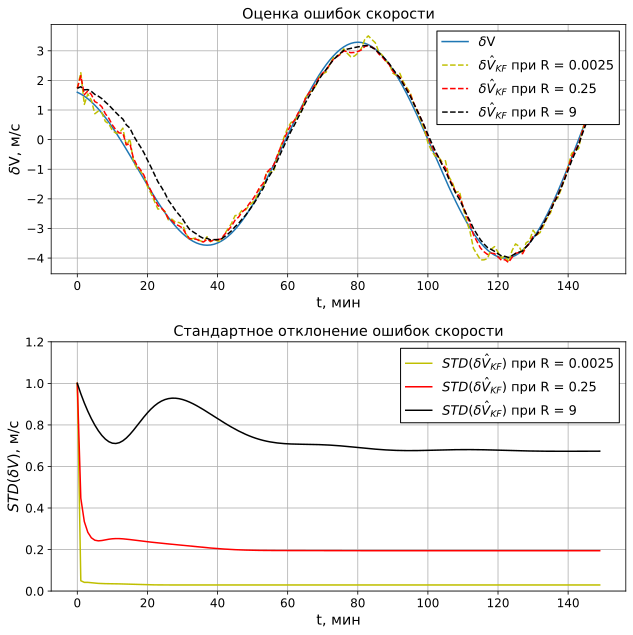

In [16]:
np.random.seed(42)
z_sco = 0.5*60
v0_sco = 1*60
phi0_sco = 1e-4
e0_sco = 1e-5
P = np.diag([v0_sco**2, phi0_sco**2, e0_sco**2])

Q = np.diag([0,0,1e-12])
R = ([(z_sco/10)**2], [(z_sco)**2], [(z_sco*6)**2])
H = np.array([[1,0,0]])


fig, ax = plt.subplots(2,1,figsize=(9,9))
ax[0].plot(t, v/60, lw=1.5, label='$\delta$V')

c = {0: 'y', 1: 'r', 2: 'k'}
i = 0
Rr = {0: '0.0025', 1: '0.25', 2: '9'}
for r in R:
    KF = KalmanFilter(P, Q, r, H)
    x_est, P_V, P_phi, P_e = KF.filtr(z)
    ax[0].plot(t, x_est[0,:]/60, '--', lw=1.5, c=c[i], label='$\delta$$\hat{V}_{KF}$ при R = '+f'{Rr[i]}')
    ax[0].grid()
    ax[0].legend(fontsize=13)
    ax[1].plot(t, np.sqrt(P_V)/60, label=r'$STD(\delta{\hat{V}}_{KF})$ при R = '+f'{Rr[i]}', c=c[i])
    i += 1
    ax[1].grid()
    ax[1].legend(fontsize=13)
    ax[1].set_ylim(0, 1.2)


ax[0].set_xlabel('t, мин')
ax[0].set_ylabel('$\delta$V, м/с')
ax[0].set_title('Оценка ошибок скорости')


ax[1].set_title('Стандартное отклонение ошибок скорости')
ax[1].set_xlabel('t, мин')
ax[1].set_ylabel('$STD(\delta{V})$, м/с')


fig.tight_layout()
plt.savefig(r'D:\мага\КП_НИР\отчет\6.png',dpi=300,bbox_inches = 'tight')



# fig1, ax1 = plt.subplots(3,1, figsize=(8,8))
# i = 0
# for r in R:
#     KF = KalmanFilter(P, Q, r, H)
#     x_est, P_V, P_phi, P_e = KF.filtr(z)
#     ax1[i].plot(t, (v-x_est[0,:])/60, lw=1.5, c=c[i], label='$\delta{V}-\delta\hat{V}_{KF}$ при R = '+f'{Rr[i]}')
#     ax1[i].plot(t, np.sqrt(P_V)/60, '--', lw=1, c='g')
#     ax1[i].plot(t, -np.sqrt(P_V)/60, '--', lw=1, c='g')
#     ax1[i].fill_between(t.ravel(), -np.sqrt(P_V)/60, np.sqrt(P_V)/60, facecolor='g', alpha=0.2)
#     ax1[i].grid()
#     ax1[i].legend()
#     ax1[i].set_ylim([-1,2])
#     ax1[i]
#     ax1[0].set_title('Ошибки фильтра в определении скорости')
#     ax1[i].set_xlabel('t, мин')
#     ax1[i].set_ylabel('$\delta{v}-\delta\hat{v}_{KF}$, м/с')
#     i += 1

# fig1.tight_layout()

In [17]:
# fig, ax = plt.subplots(2,1,figsize=(8,8))
# ax[0].plot(t, phi, lw=1.5, label='$\Phi$')

# c = {0: 'y', 1: 'r', 2: 'k'}
# i = 0
# Rr = {0: '0.0025', 1: '0.25', 2: '9'}

# for r in R:
#     KF = KalmanFilter(P, Q, r, H)
#     x_est, P_V, P_phi, P_e = KF.filtr(z)
#     ax[0].plot(t, x_est[1,:],'--',  lw=1.5, c=c[i], label='$\hat{\Phi}_{KF}$ при R = '+f'{Rr[i]}')
#     ax[0].grid()
#     ax[0].legend()
#     ax[1].plot(t, np.sqrt(P_phi), label=r'$STD(\hat{\Phi}_{KF})$ при R = '+f'{Rr[i]}', c=c[i])
#     i += 1
#     ax[1].grid()
#     ax[1].legend()


# ax[0].ticklabel_format(axis='y', scilimits=[-3, 3])
# ax[0].set_xlabel('t, мин')
# ax[0].set_ylabel('$\Phi$, рад')
# ax[0].set_title('Ошибки ИНС в определении угла отклонения ГСП')


# ax[1].set_title('Стандартное отклонение ошибок угла отклонения ГСП')
# ax[1].ticklabel_format(axis='y', scilimits=[-3, 3])
# ax[1].set_ylabel('$STD(\Phi)$, рад')
# ax[1].set_xlabel('t, мин')


# fig.tight_layout()
# plt.savefig(r'D:\мага\КП_НИР\отчет\9.png',dpi=300)



# fig1, ax1 = plt.subplots(3,1, figsize=(8,8))
# i = 0
# for r in R:
#     KF = KalmanFilter(P, Q, r, H)
#     x_est, P_V, P_phi, P_e = KF.filtr(z)
#     ax1[i].plot(t, (phi-x_est[1,:]),  lw=1.5, c=c[i], label='$\Phi-\hat{\Phi}_{KF}$ при R = '+f'{Rr[i]}')
#     ax1[i].plot(t, np.sqrt(P_phi), '--', lw=1, c='g')
#     ax1[i].plot(t, -np.sqrt(P_phi), '--', lw=1, c='g')
#     ax1[i].fill_between(t.ravel(), -np.sqrt(P_phi), np.sqrt(P_phi), facecolor='g', alpha=0.2)
#     ax1[i].grid()
#     ax1[i].legend()
# #     ax1[i].set_ylim([-1,2])
#     ax1[i]
#     ax1[0].set_title('Ошибки фильтра в определении угла отклонения ГСП')
#     ax1[i].set_xlabel('t, мин')
#     ax1[i].set_ylabel('$\Phi-\hat{\Phi}_{KF}$, рад')
#     ax1[i].ticklabel_format(axis='y', scilimits=[-3, 3])
#     i += 1
    
# fig1.tight_layout()

In [18]:
# fig, ax = plt.subplots(2,1,figsize=(8,8))

# ax[0].plot(t, e, lw=1.5, label='$\epsilon$')

# c = {0: 'y', 1: 'r', 2: 'k'}
# i = 0
# Rr = {0: '0.0025', 1: '0.25', 2: '9'}
# for r in R:
#     KF = KalmanFilter(P, Q, r, H)
#     x_est, P_V, P_phi, P_e = KF.filtr(z)
#     ax[0].plot(t, x_est[2,:], '--', lw=1.5, c=c[i], label='$\hat{\epsilon}_{KF}$ при R = '+f'{Rr[i]}')
#     ax[0].grid()
#     ax[0].legend()
#     ax[1].plot(t, np.sqrt(P_e), c=c[i], label=r'$STD(\hat{\epsilon}_{KF})$ при R = '+f'{Rr[i]}')
#     ax[1].grid()
#     ax[1].legend()
#     i += 1




# ax[0].ticklabel_format(axis='y', scilimits=[-3, 3])
# ax[0].set_xlabel('t, мин')
# ax[0].set_ylabel('$\epsilon$, рад/с')
# ax[0].set_title('Ошибки ИНС в определении скорости дрейфа ГСП')


# ax[1].set_title('Стандартное отклонение скорости дрейфа ГСП')
# ax[1].ticklabel_format(axis='y', scilimits=[-3, 3])
# ax[1].set_ylabel('$STD(\epsilon)$, рад')
# ax[1].set_xlabel('t, мин')

# fig.tight_layout()
# plt.savefig(r'D:\мага\КП_НИР\отчет\10.png',dpi=300)


# fig1, ax1 = plt.subplots(3,1, figsize=(8,8))
# i = 0
# for r in R:
#     KF = KalmanFilter(P, Q, r, H)
#     x_est, P_V, P_phi, P_e = KF.filtr(z)
#     ax1[i].plot(t, (e-x_est[2,:])/60,  lw=1.5, c=c[i], label='$\epsilon-\hat{\epsilon}_{KF}$ при R = '+f'{Rr[i]}')
#     ax1[i].plot(t, np.sqrt(P_e)/60, '--', lw=1, c='g')
#     ax1[i].plot(t, -np.sqrt(P_e)/60, '--', lw=1, c='g')
#     ax1[i].fill_between(t.ravel(), -np.sqrt(P_e)/60, np.sqrt(P_e)/60, facecolor='g', alpha=0.2)
#     ax1[i].grid()
#     ax1[i].legend()
# #     ax1[i].set_ylim([-1,2])
#     ax1[i]
#     ax1[0].set_title('Ошибки фильтра в определении скорости дрейфа ГСП')
#     ax1[i].set_xlabel('t, мин')
#     ax1[i].set_ylabel('$\epsilon-\hat{\epsilon}_{KF}$, рад/с')
#     i += 1
    
# fig1.tight_layout()

In [19]:
np.random.seed(42)
class NKalmanFilter:
    def __init__(self,P, Q, R, H):
        self.P = P #cov matrix state
        self.Q = Q #cov matrix process
        self.R = R #cov matrix measure
        self.H = H #matrix measure
        self.K = np.array([[0,0,0]]).T
        self.x_est = np.array([[5*60], [0], [0]])
        self.P_V = np.array(self.P[0,0])
        self.P_phi = np.array(self.P[1,1])
        self.P_e = np.array(self.P[2,2])
        
        T = 1 # период дискретизации 1 сек
        b = 0.05 # cредняя частота случайного дрейфа с^-1
        R = 6370000 # Радиус земли м
        g =  9.8*3600 #ускорение свободного падения м/с**2
        self.F = np.array([[1,  -g*T,  0],
                      [T/R, 1,  T],
                      [0,   0,  1-b*T]])

    def filtr(self, z):
        
        for i in range(1, len(z)):
            #predict
            x = self.F @ self.x_est[:,-1][:,np.newaxis]
            y = z[i] - self.H @ x
            self.P = self.F @ self.P @ self.F.T + self.Q
            
            #update
            Ht = self.H.T
            K = self.P @ Ht @ np.linalg.inv(self.H @ self.P @ Ht + self.R)
            self.x_est = np.hstack((self.x_est, x + K @ y))
            I = np.eye(len(x))
            self.P = (I - K @ self.H) @ self.P
            self.K = K
            
            #logs
            self.P_V = np.hstack((self.P_V,self.P[0,0]))
            self.P_phi = np.hstack((self.P_phi,self.P[1,1]))
            self.P_e = np.hstack((self.P_e,self.P[2,2]))
  
        
        return self.x_est, self.P_V, self.P_phi, self.P_e

При неточном задании начала

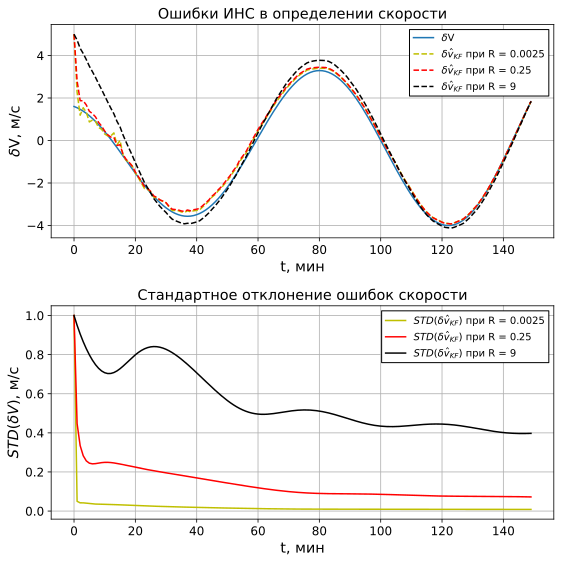

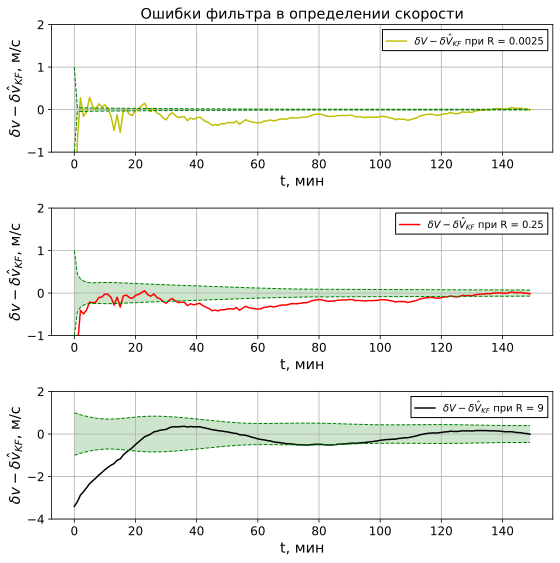

In [20]:
np.random.seed(42)
z_sco = 0.5*60
v0_sco = 1*60
phi0_sco = 1e-4
e0_sco = 1e-5
P = np.diag([v0_sco**2, phi0_sco**2, e0_sco**2])

Q = np.diag([0,0,1e-16])
R = ([(z_sco/10)**2], [(z_sco)**2], [(z_sco*6)**2])
H = np.array([[1,0,0]])


fig, ax = plt.subplots(2,1,figsize=(8,8))

ax[0].plot(t, v/60, lw=1.5, label='$\delta$V')

c = {0: 'y', 1: 'r', 2: 'k'}
i = 0
Rr = {0: '0.0025', 1: '0.25', 2: '9'}
for r in R:
    KF = NKalmanFilter(P, Q, r, H)
    x_est, P_V, P_phi, P_e = KF.filtr(z)
    ax[0].plot(t, x_est[0,:]/60, '--', lw=1.5, c=c[i], label='$\delta$$\hat{v}_{KF}$ при R = '+f'{Rr[i]}')
    ax[0].grid()
    ax[0].legend()
    ax[1].plot(t, np.sqrt(P_V)/60, label=r'$STD(\delta{\hat{v}}_{KF})$ при R = '+f'{Rr[i]}', c=c[i])
    i += 1
    ax[1].grid()
    ax[1].legend()


ax[0].set_xlabel('t, мин')
ax[0].set_ylabel('$\delta$V, м/с')
ax[0].set_title('Ошибки ИНС в определении скорости')
# plt.savefig(r'D:\мага\КП_НИР\отчет\saved_figure.png')


ax[1].set_title('Стандартное отклонение ошибок скорости')
ax[1].set_xlabel('t, мин')
ax[1].set_ylabel('$STD(\delta{V})$, м/с')

fig.tight_layout()
plt.savefig(r'D:\мага\КП_НИР\отчет\11.png',dpi=300)



fig1, ax1 = plt.subplots(3,1, figsize=(8,8))
i = 0
for r in R:
    KF = NKalmanFilter(P, Q, r, H)
    x_est, P_V, P_phi, P_e = KF.filtr(z)
    ax1[i].plot(t, (v-x_est[0,:])/60, lw=1.5, c=c[i], label='$\delta{V}-\delta\hat{V}_{KF}$ при R = '+f'{Rr[i]}')
    ax1[i].plot(t, np.sqrt(P_V)/60, '--', lw=1, c='g')
    ax1[i].plot(t, -np.sqrt(P_V)/60, '--', lw=1, c='g')
    ax1[i].fill_between(t.ravel(), -np.sqrt(P_V)/60, np.sqrt(P_V)/60, facecolor='g', alpha=0.2)
    ax1[i].grid()
    ax1[i].legend()
    ax1[i].set_ylim([-1,2])
    ax1[i]
    ax1[0].set_title('Ошибки фильтра в определении скорости')
    ax1[i].set_xlabel('t, мин')
    ax1[i].set_ylabel('$\delta{v}-\delta\hat{v}_{KF}$, м/с')
    i += 1

ax1[2].set_ylim([-4,2])
fig1.tight_layout()

In [21]:
x_est[0,:]/60

array([ 5.        ,  4.72533209,  4.33832258,  4.09264889,  3.80804132,
        3.49569569,  3.23884988,  2.97132177,  2.6762712 ,  2.39677813,
        2.09797406,  1.8060736 ,  1.5215602 ,  1.2551715 ,  0.90154849,
        0.64100163,  0.25327136, -0.0807444 , -0.38958106, -0.70509106,
       -1.04657366, -1.36458416, -1.68227441, -1.99030006, -2.22694818,
       -2.46716799, -2.73149301, -2.91353224, -3.10104784, -3.24987097,
       -3.38734074, -3.56028865, -3.7004716 , -3.77167008, -3.82862772,
       -3.88738268, -3.92056187, -3.89682121, -3.91200556, -3.87201211,
       -3.83384408, -3.77548681, -3.66335521, -3.54118198, -3.40240156,
       -3.23630188, -3.08267552, -2.89905388, -2.72007287, -2.51395277,
       -2.30251697, -2.07422648, -1.82623775, -1.59085367, -1.30095127,
       -1.05122679, -0.79738917, -0.50413546, -0.21321938,  0.07685326,
        0.36697532,  0.64680192,  0.91159363,  1.1852357 ,  1.44247909,
        1.71497857,  1.96275679,  2.19044818,  2.413407  ,  2.63

In [64]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook 
import plotly.graph_objs as go

class KalmanFilterNOISE:
    def __init__(self,P, Q, R, H):
        self.P = P #cov matrix state
        self.Q = Q #cov matrix process
        self.R = R #cov matrix measure
        self.H = H #matrix measure
        self.K = np.array([0])
        self.x_est = np.array([0])
        self.F = 1

    def filtr(self, z):
        self.x_est[0] = z[0]
        for i in range(1, len(z)):
            #predict
            x = self.F * self.x_est[-1]
            y = z[i] - self.H * x
            self.P = self.F * self.P * self.F + self.Q
            
            #update
            K = self.P * H * 1/(self.H * self.P * self.H + self.R)
            self.x_est = np.hstack((self.x_est, x + K * y))
            self.P = (1 - K * self.H) * self.P
            self.K = K 
        
        return self.x_est

P = np.array([10])
Q = np.array([0.01])
R = np.array([0.09])
H = np.array([1])
t = np.arange(300)
x = 15*np.zeros(300)
x[100:200] = 2
x[200:300] = 10
z =  x + 30*np.random.rand(300)

K = KalmanFilterNOISE(P, Q, R, H)
x_est = K.filtr(z)


fig = go.Figure()

# fig = plt.figure(figsize=(8,7))
# ax = plt.subplot(111)
# ax.plot(t, z)
# ax.plot(t, x_est)
est = np.zeros(len(z))
m = []
a = 0
for i in range(len(z)):
    m.append(z[i])
    if len(m) >= 5:
        a = np.mean(m[-5:])
    est[i] = a
# ax.plot(t, est)   
# ax.plot(t, x_est)  

def moving_average(a, n=5):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
    
x_est_a = moving_average(z, n=5)  
fig.add_trace(go.Scatter(x=t, y=z))
fig.add_trace(go.Scatter(x=t, y=x_est_a))
fig.add_trace(go.Scatter(x=t, y=est))

In [62]:
a = [1,2,3]
a[-2:]

[2, 3]